Let's import what's needed:

In [1]:
!pip install torch torchvision

In [2]:
%matplotlib inline
from typing import Tuple
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)

If you do not have e.g. PyTorch installed in a Colab environment, you can do
`!pip install torch torchvision`.

# Task 1

Let's create a tensor:

In [3]:
xx = torch.linspace(-3, 3, 50)
xx

tensor([-3.0000, -2.8776, -2.7551, -2.6327, -2.5102, -2.3878, -2.2653, -2.1429,
        -2.0204, -1.8980, -1.7755, -1.6531, -1.5306, -1.4082, -1.2857, -1.1633,
        -1.0408, -0.9184, -0.7959, -0.6735, -0.5510, -0.4286, -0.3061, -0.1837,
        -0.0612,  0.0612,  0.1837,  0.3061,  0.4286,  0.5510,  0.6735,  0.7959,
         0.9184,  1.0408,  1.1633,  1.2857,  1.4082,  1.5306,  1.6531,  1.7755,
         1.8980,  2.0204,  2.1429,  2.2653,  2.3878,  2.5102,  2.6327,  2.7551,
         2.8776,  3.0000])

You can also create a tensor by explicitly specifying its elements:

In [4]:
another_tensor = torch.tensor([1, 2, 3])
yet_another = torch.tensor([1.0, 2.0, 3.0])
# What is the difference?
print('The type of the elements in `another_tensor`:', another_tensor.dtype)
print('The type of the elements in `yet_another`:', yet_another.dtype)

The type of the elements in `another_tensor`: torch.int64
The type of the elements in `yet_another`: torch.float32


Before we go ahead with the automatic differentiation, another feature compared
to Numpy is that Torch tensors can be moved to GPUs (or other accelerator
hardware) for faster computation. This is done by the `to('cuda')` or `cuda()`
method calls. Check the documentation whether they return a new variable.

In [5]:
#another_tensor = another_tensor.to('cuda')
#assert another_tensor.device == torch.device('cuda') # TODO place `another_tensor` onto the GPU
another_tensor = another_tensor.to('cpu')
assert another_tensor.device == torch.device('cpu') # TODO move it back to the CPU


The API is very similar to Numpy, but there are a couple of differences.
(For example, what is the Torch equivalent of `np.array_equal()`?)

Let's plot our function $f(x) = \sigma^2(x)$:

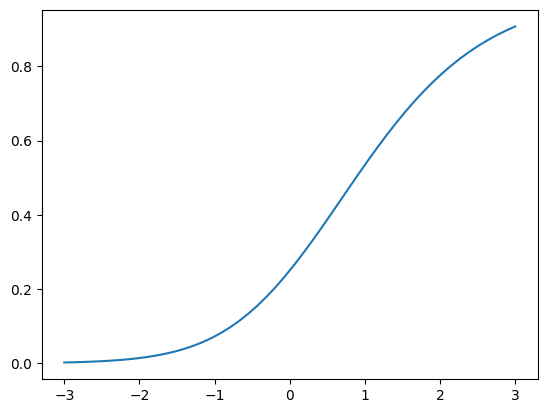

In [6]:
xx = torch.linspace(-3, 3, 50)
yy = torch.sigmoid(xx)**2  # yes, sigmoid is built in!
plt.plot(xx, yy)

## Taking derivatives

For a bit more complicated function, calculate its derivative:

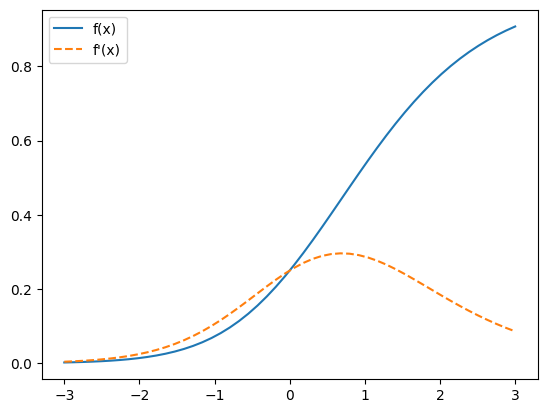

In [7]:
# vectorized way
xx = torch.linspace(-3, 3, 50, requires_grad=True)
yy = torch.sigmoid(xx)**2
yy.sum().backward()

plt.plot(xx.detach().numpy(), yy.detach().numpy(), label='f(x)')
plt.plot(xx.detach().numpy(), xx.grad.numpy(), label="f'(x)", linestyle='--')
plt.legend()

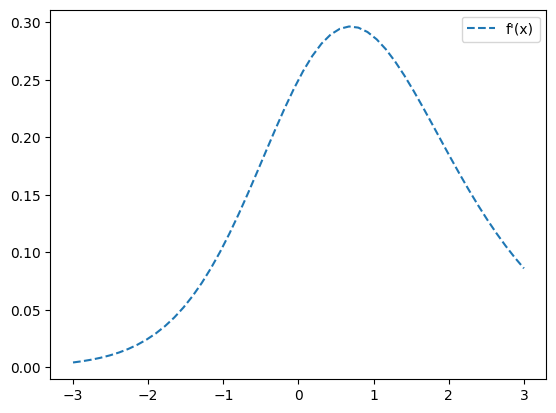

In [8]:
# element-by-element way
xx = torch.linspace(-3, 3, 50)
yy_prime = []
for x in xx:
    x.requires_grad = True
    y = torch.sigmoid(x)**2
    y.backward()
    yy_prime.append(x.grad)

plt.plot(xx.detach().numpy(), yy_prime, label="f'(x)", linestyle='--')
plt.legend()

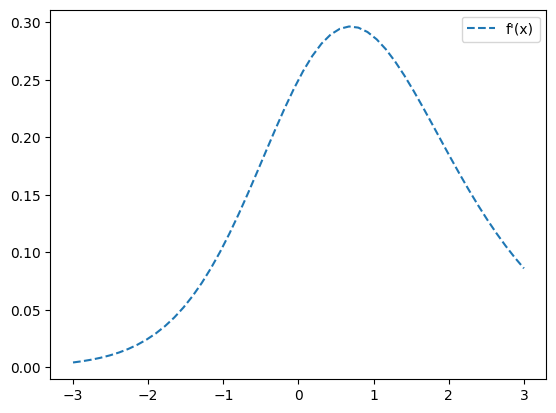

In [9]:
# comparing to analytical
xx = torch.linspace(-3, 3, 50)
yy = torch.sigmoid(xx)**2
yy_prime = 2 * torch.sigmoid(xx)**2 * (1 - torch.sigmoid(xx))

plt.plot(xx.detach().numpy(), yy_prime, label="f'(x)", linestyle='--')
plt.legend()

In [10]:
# Another way of using PyTorch's builtin mechanisms:
N = 50
gradient = torch.zeros(N)
# Unfortunately, PyTorch can only take the gradient at a single point at a
# time, so we need a for loop:
for i, x_value in enumerate(np.linspace(-3, 3, N)):
    # we will mark the variables we need the gradient _with respect to_
    # xx = torch.linspace(-3, 3, 500, requires_grad=True)
    x = torch.tensor(x_value, requires_grad=True)
    if i == 0:
        print('`x` requires grad:', x.requires_grad)
    # we need to complete the calculations as before (this is sometimes called
    # the forward pass)
    y = torch.sigmoid(x)**2
    # this line calculates the gradients for all variables that "need grad"
    # (sometimes called the backward pass)
    y.backward()
    # and now, what we have been waiting for:
    gradient[i] = x.grad
# Always check with `allclose` and not `==` if they are floating point tensors
print('AD and analytic gradients equal:',
      torch.allclose(yy_prime, gradient))

`x` requires grad: True
AD and analytic gradients equal: True


# Task 2

This is going to be our objective function to optimise (minimise):

In [11]:
def f(x):
    x = torch.atleast_2d(x)
    assert x.shape[1] == 2, 'Second dimension should contain the input features'
    # Himmelblau
    x1 = x[:, 0]
    x2 = x[:, 1]
    return ((x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2)

In [12]:
def plot_contour():
    N = 500
    xx = torch.linspace(-6, 6, N)
    x1, x2 = torch.meshgrid(xx, xx, indexing='ij')
    x = torch.stack((x1.ravel(), x2.ravel()), axis=1)
    y = f(x).reshape(N, N)
    fig, (ax, ax_log) = plt.subplots(
        1, 2, figsize=(10, 5), layout='constrained')
    ax.contourf(x1, x2, y, levels=20)
    ax.grid()
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Linear scale')
    ax_log.contourf(x1, x2, torch.log(y), levels=20)
    ax_log.grid()
    ax_log.set_xlabel('$x_1$')
    ax_log.set_ylabel('$x_2$')
    ax_log.set_title('Log scale')
    return fig, (ax, ax_log)

Let's start by optimising by hand:

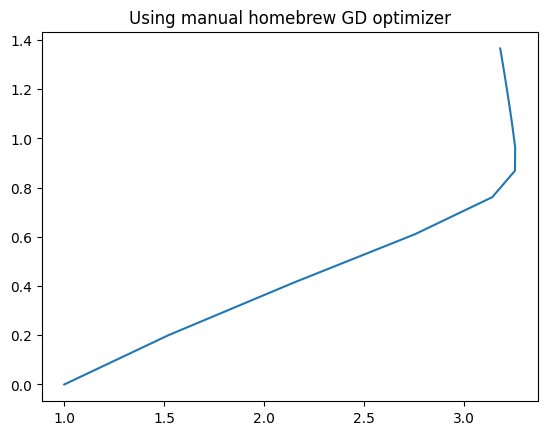

In [13]:
x = torch.tensor([1., 0.], requires_grad=True) # initial guess
# we need to clone and detach so as not to copy the meta information, only the values
trajectory_1 = [x.clone().detach()]
step_size = 0.01
for i in range(10):
    # zero out the gradients (because we reuse the tensor)
    x.grad = None

    y = f(x)
    y.backward()

    # step in the direction of the negative gradient
    # we need to temporarily disable autograd for this:
    with torch.no_grad():
        x.add_(-x.grad * step_size)
    trajectory_1.append(x.clone().detach())
plt.title('Using manual homebrew GD optimizer')
plt.plot([t[0] for t in trajectory_1], [t[1] for t in trajectory_1])

And by using the built in optimisers:

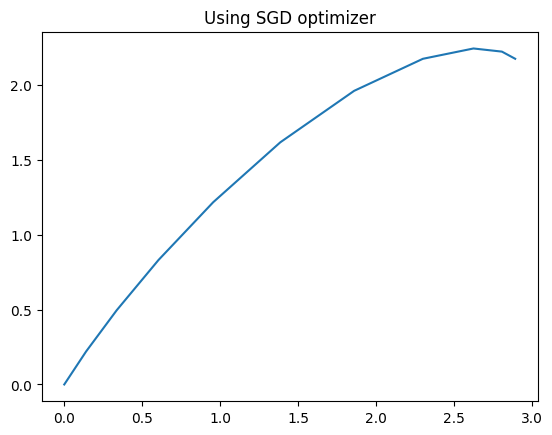

In [14]:
x = torch.tensor([0., 0.], requires_grad=True)  # initial guess
# we need to clone and detach so as not to copy the meta information, only the values
trajectory_2 = [x.clone().detach()]
# we need to tell the optimiser which parameters to optimise
optimiser = optim.SGD(params=[x], lr=step_size)
for i in range(10):
    # zero out the gradients
    optimiser.zero_grad()
    # forward pass
    y = f(x)
    # calculate the gradient
    y.backward()
    # step in the direction of the negative gradient
    optimiser.step()
    # save trajectory
    trajectory_2.append(x.clone().detach())
plt.title('Using SGD optimizer')
plt.plot([t[0] for t in trajectory_2], [t[1] for t in trajectory_2])

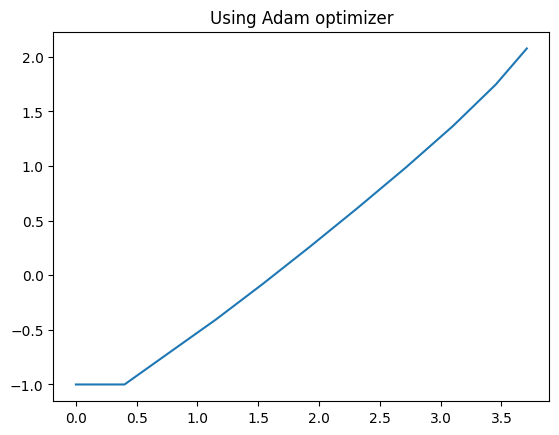

In [15]:
x = torch.tensor([0., -1.], requires_grad=True)  # initial guess
# we need to clone and detach so as not to copy the meta information, only the values
trajectory_3 = [x.clone().detach()]
# we need to tell the optimiser which parameters to optimise
optimiser = optim.Adam(params=[x], lr=step_size*40)

for i in range(10):
    # zero out the gradients
    optimiser.zero_grad()
    # forward pass
    y = f(x)
    # calculate the gradient
    y.backward()
    # step in the direction of the negative gradient
    optimiser.step()
    # save trajectory
    trajectory_3.append(x.clone().detach())
plt.title('Using Adam optimizer')
plt.plot([t[0] for t in trajectory_3], [t[1] for t in trajectory_3])

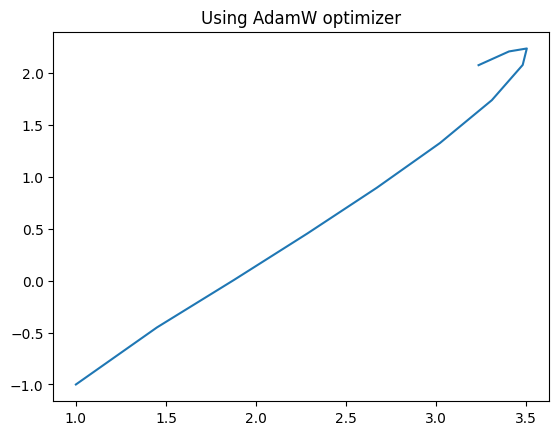

In [16]:
x = torch.tensor([1., -1.], requires_grad=True)  # initial guess
# we need to clone and detach so as not to copy the meta information, only the values
trajectory_4 = [x.clone().detach()]
optimiser = optim.AdamW(params=[x], lr=step_size*50, betas=(0.9, 0.999), weight_decay=1e-1)

for i in range(10):
    # zero out the gradients
    optimiser.zero_grad()
    # forward pass
    y = f(x)
    # calculate the gradient
    y.backward()
    # step in the direction of the negative gradient
    optimiser.step()
    # save trajectory
    trajectory_4.append(x.clone().detach())
plt.title('Using AdamW optimizer')
plt.plot([t[0] for t in trajectory_4], [t[1] for t in trajectory_4])

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


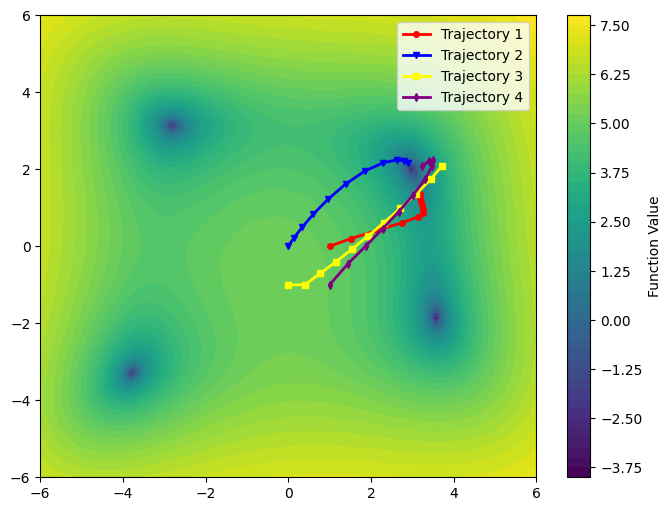

In [17]:
num_points = 100
x1_values = torch.linspace(-6, 6, num_points)
x2_values = torch.linspace(-6, 6, num_points)
x1_grid, x2_grid = torch.meshgrid(x1_values, x2_values)
inputs = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)  # Flatten to 2D array of shape (num_points**2, 2)

outputs = f(inputs)
outputs_grid = outputs.reshape(num_points, num_points)

plt.figure(figsize=(8, 6))
plt.contourf(x1_grid, x2_grid, torch.log(outputs_grid), levels=50, cmap='viridis')  # Contour plot
plt.colorbar(label='Function Value')
plt.plot([t[0] for t in trajectory_1], [t[1] for t in trajectory_1], color='red', marker='o', markersize=4, linewidth=2, label='Trajectory 1')
plt.plot([t[0] for t in trajectory_2], [t[1] for t in trajectory_2], color='blue', marker='v', markersize=4, linewidth=2, label='Trajectory 2')
plt.plot([t[0] for t in trajectory_3], [t[1] for t in trajectory_3], color='yellow', marker='s', markersize=4, linewidth=2, label='Trajectory 3')
plt.plot([t[0] for t in trajectory_4], [t[1] for t in trajectory_4], color='purple', marker='d', markersize=4, linewidth=2, label='Trajectory 4')
plt.legend()

# Task 3

Let's start by loading the dataset:

In [18]:
batch_size = 32
num_epochs = 10

In [19]:
train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
# PyTorch has these DataLoaders which make batching and iterating really
# convenient
train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False)

Let's define our model, which is going to be a neural network:

In [20]:
class MnistClassifier(nn.Module):
    NUM_CLASSES = 10
    NUM_INPUT_CHANNELS = 1

    def __init__(self):
        # always call super with PyTorch models
        super().__init__()
        # the parameters within these will automatically get registered, and
        # will be tracked by the optimiser
        self.conv1 = nn.Conv2d(in_channels=self.NUM_INPUT_CHANNELS, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=1, kernel_size=3, stride=2)
        self.fc = nn.Linear(1 * 5 * 5, self.NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc(x)
        return x

And then do the training loop:

Epoch 1/10	| Epoch average loss: 2.3030 (train), 2.3013 (test)
Epoch 2/10	| Epoch average loss: 2.3012 (train), 2.3008 (test)
Epoch 3/10	| Epoch average loss: 2.2978 (train), 2.2769 (test)
Epoch 4/10	| Epoch average loss: 0.9974 (train), 0.4845 (test)
Epoch 5/10	| Epoch average loss: 0.4818 (train), 0.4325 (test)
Epoch 6/10	| Epoch average loss: 0.4513 (train), 0.4122 (test)
Epoch 7/10	| Epoch average loss: 0.4287 (train), 0.4137 (test)
Epoch 8/10	| Epoch average loss: 0.4124 (train), 0.3935 (test)
Epoch 9/10	| Epoch average loss: 0.3987 (train), 0.3657 (test)
Epoch 10/10	| Epoch average loss: 0.3856 (train), 0.3645 (test)


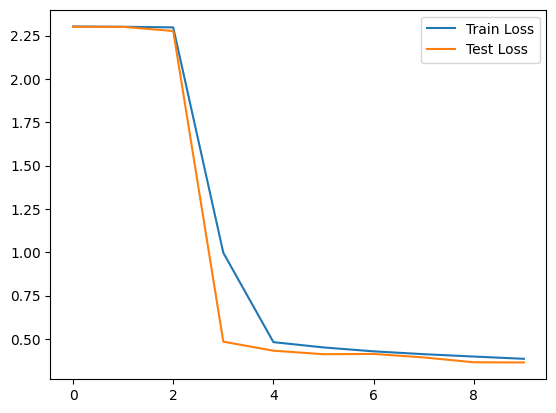

In [21]:
def train_epoch(train_loader, test_loader, model, optimiser) -> Tuple[float, float]:
    criterion = nn.CrossEntropyLoss()
    total_loss_train = 0.0
    total_loss_test = 0.0

    # Training phase
    for x, y in train_loader:  # Mini-batch
        optimiser.zero_grad()  # Clear the gradients before each step
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimiser.step()  # Update model weights
        total_loss_train += loss.item()

    # Testing phase
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            y_hat = model(x)
            loss = criterion(y_hat, y)
            total_loss_test += loss.item()
    return total_loss_train / len(train_loader), total_loss_test / len(test_loader)

model = MnistClassifier()
optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
losses_train = []
losses_test = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}\t| ', end='')
    loss_train, loss_test = train_epoch(train_loader, test_loader, model, optimiser)
    print(f'Epoch average loss: {loss_train:.4f} (train), {loss_test:.4f} (test)')
    losses_train.append(loss_train)
    losses_test.append(loss_test)
plt.plot(losses_train, label='Train Loss')
plt.plot(losses_test, label='Test Loss')
plt.legend()

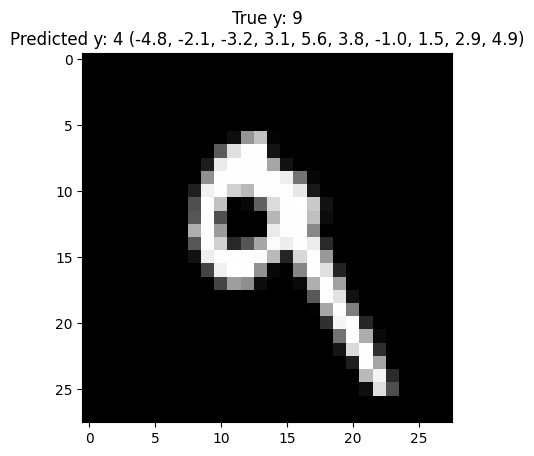

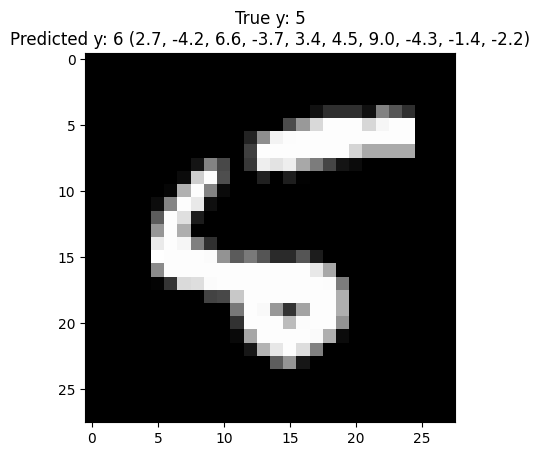

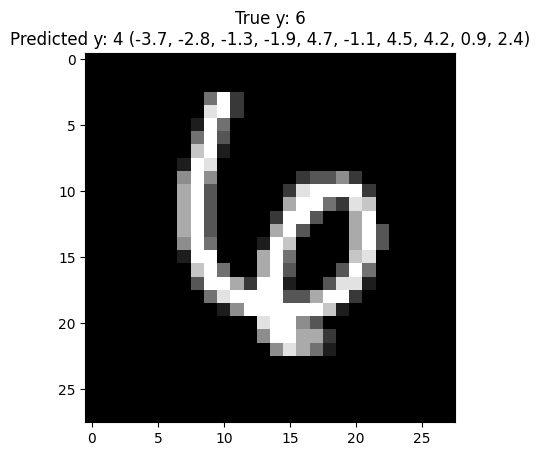

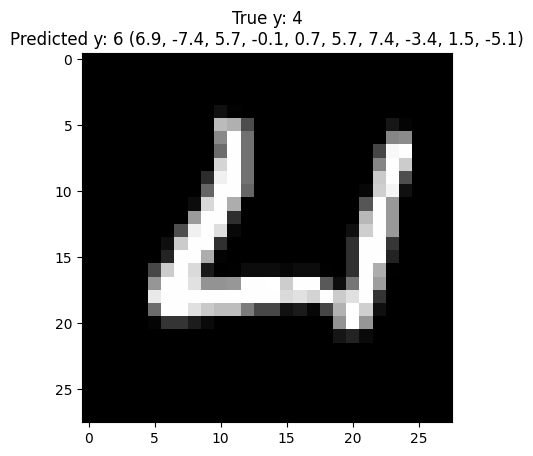

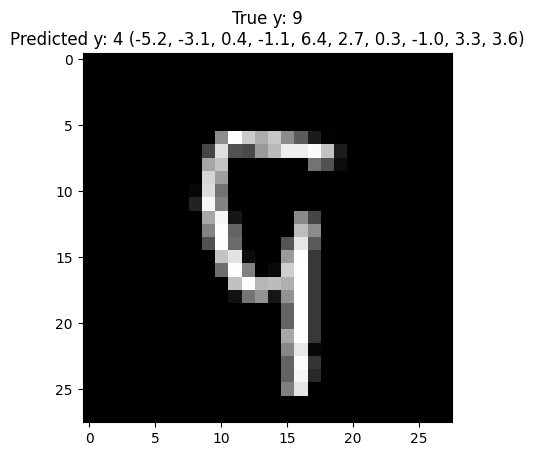

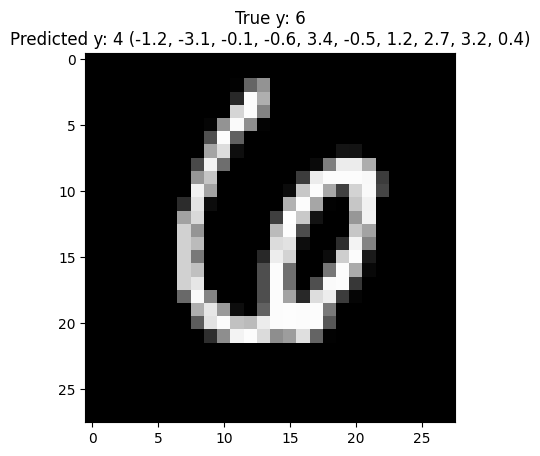

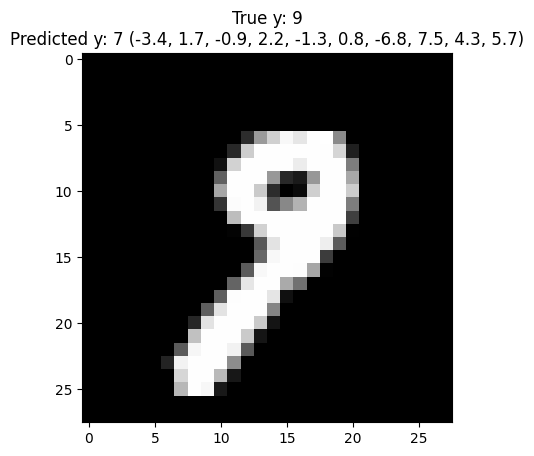

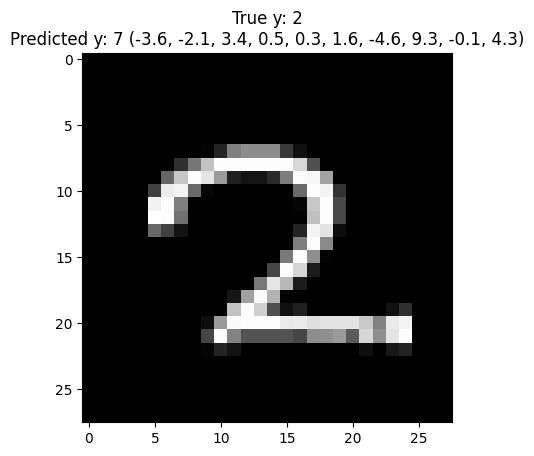

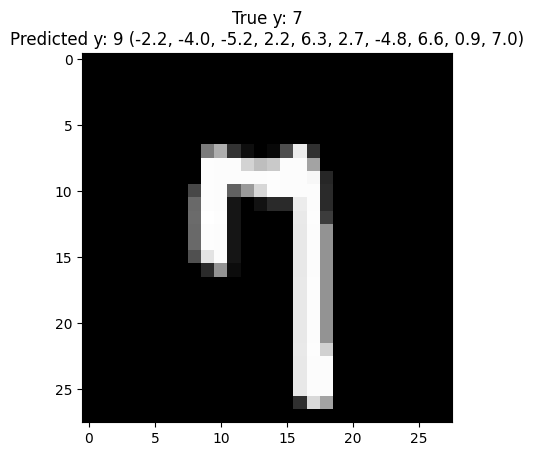

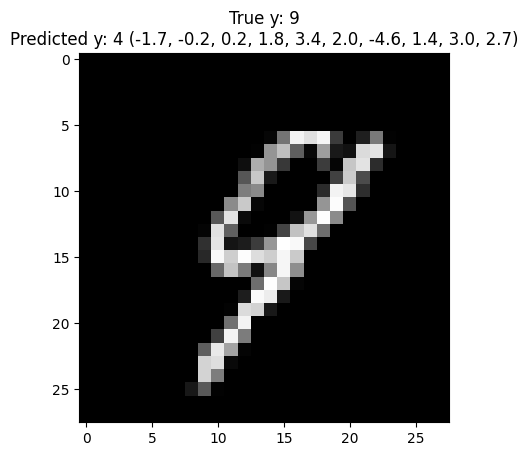

In [24]:
# plot n mistakes
n=10
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
      for x, y in zip(x_batch, y_batch):
        if n <= 0:
          break
        y_hat = model(x)
        if torch.argmax(y_hat) != y:
          plt.imshow(x[0], cmap='gray')
          plt.title(f'True y: {y.numpy()}\nPredicted y: {torch.argmax(y_hat).numpy()} ({", ".join([format(v, ".1f") for v in y_hat[0].numpy()])})')
          plt.show()
          n -= 1

# Task 4

----------------------------------------
Layer size: 3
Epoch 1/10	| Epoch average loss: 2.2798 (train), 677.3517338037491 (test)
Epoch 2/10	| Epoch average loss: 2.0198 (train), 590.2467224597931 (test)
Epoch 3/10	| Epoch average loss: 1.7700 (train), 519.2990233898163 (test)
Epoch 4/10	| Epoch average loss: 1.5737 (train), 463.92624711990356 (test)
Epoch 5/10	| Epoch average loss: 1.4272 (train), 423.66477739810944 (test)
Epoch 6/10	| Epoch average loss: 1.3204 (train), 393.7282737493515 (test)
Epoch 7/10	| Epoch average loss: 1.2399 (train), 371.52659958601 (test)
Epoch 8/10	| Epoch average loss: 1.1760 (train), 353.2267071008682 (test)
Epoch 9/10	| Epoch average loss: 1.1247 (train), 338.7740623950958 (test)
Epoch 10/10	| Epoch average loss: 1.0818 (train), 327.31662714481354 (test)
----------------------------------------
Layer size: 5
Epoch 1/10	| Epoch average loss: 2.1626 (train), 615.7394064664841 (test)
Epoch 2/10	| Epoch average loss: 1.7743 (train), 491.10581052303314 (test)

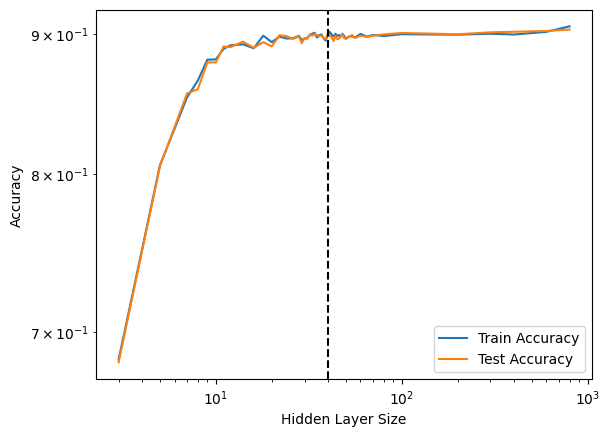

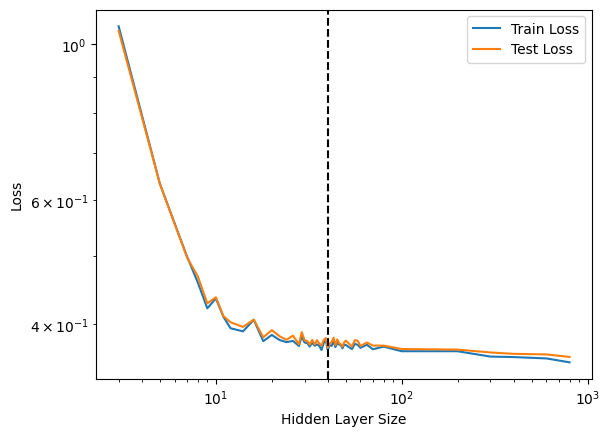

In [ ]:
class FullyConnectedModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def evaluate(model, loader):
    '''
    return the accuracy and the loss
    '''
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total, total_loss / len(loader)

# Reduce training data to 4000 samples
train_data_subset = random.sample(list(train), 8000)
train_loader_subset = torch.utils.data.DataLoader(train_data_subset, batch_size=batch_size, shuffle=True)

layer_sizes = [
    3, 5, 7, #underfit
    8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 24, 26, # good fit
    28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, # overfit
    52, 54, 56, 58, 60,
    65, 70, 80, 100, 200, 300, 400, 600, 800,  # amazing fit
]
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for size in layer_sizes:
    print('-'*40)
    print(f'Layer size: {size}')
    model = FullyConnectedModel(hidden_size=size)
    optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}\t| ', end='')
        train_epoch(train_loader_subset, test_loader, model, optimiser)

    train_acc, train_loss = evaluate(model, train_loader_subset)
    test_acc, test_loss = evaluate(model, test_loader)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot accuracies
plt.plot(layer_sizes, train_accuracies, label='Train Accuracy')
plt.plot(layer_sizes, test_accuracies, label='Test Accuracy')
plt.axvline(x=40, color='black', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Plot losses
plt.plot(layer_sizes, train_losses, label='Train Loss')
plt.plot(layer_sizes, test_losses, label='Test Loss')
plt.axvline(x=40, color='black', linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Loss')
plt.legend()
plt.show()

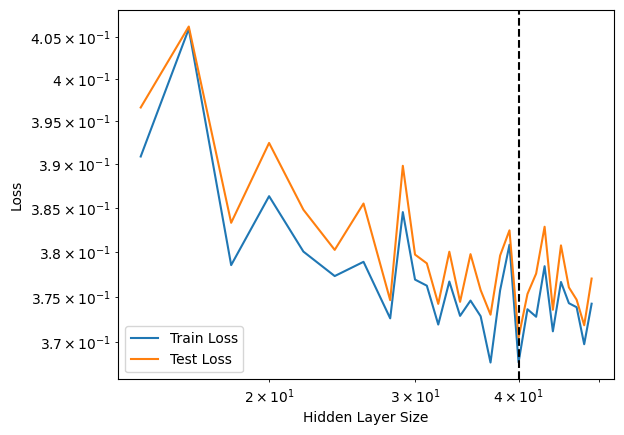

In [ ]:
# Zoom in interesting area
min_index = min(range(len(layer_sizes)), key=lambda i: abs(layer_sizes[i] - 15))
max_index = min(range(len(layer_sizes)), key=lambda i: abs(layer_sizes[i] - 50))

plt.plot(layer_sizes[min_index:max_index], train_losses[min_index:max_index], label='Train Loss')
plt.plot(layer_sizes[min_index:max_index], test_losses[min_index:max_index], label='Test Loss')
plt.axvline(x=40, color='black', linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Loss')
plt.legend()
plt.show()

The curve we obtained is _somewhat_ similar to the curve obtained by the paper:


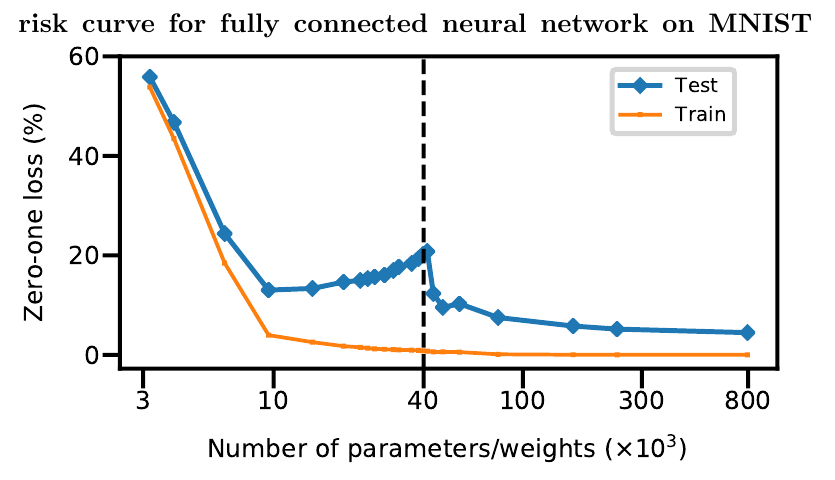


However:
* The transition from classical regime to interpolating regime is less clear
* At the interpolation point, test and train losses are not much different, indicating none (or little) overfit
* At the "ideal fit" point (between underfit and overfit), loss is just slightly lower than the interpolation point.
* The curve is more noisy.

Those differences may have arised from differences in our experimental setup:
* Using only 6000 samples in the MNIST dataset
* Differences in the optimizer
* Differences in the model (the paper says they used a fully connected two-layer neural, but maybe there is some small implementation difference)
* We are plotting CrossEntropyLoss, not zero-one loss